In [1]:
import os
import sys
os.environ["THEANO_FLAGS"] = "device=gpu"
sys.path.append(os.getcwd()+"/..")
from tasks import check

Using gpu device 0: Tesla K20Xm (CNMeM is disabled, CuDNN 3007)
/home/mcherti/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from model import model50, model51, model51, model52

In [3]:
all_layers = model52(nb_filters=128, w=32, h=32, c=3)

In [4]:
import theano.tensor as T
import theano
from lasagne import layers

X_scale1 = T.tensor4()
X_scale2 = T.tensor4()
X_scale3 = T.tensor4()
X_scale4 = T.tensor4()

X_scale1_out = T.tensor4()
X_scale2_out = T.tensor4()
X_scale3_out = T.tensor4()
X_scale4_out = T.tensor4()


input_tensors = [X_scale1, X_scale2, X_scale3, X_scale4]
output_tensors = [X_scale1_out, X_scale2_out, X_scale3_out, X_scale4_out]

input_layers = ["scale1_input", "scale2_input", "scale3_input", "scale4_input"]
output_layers = ["scale1_output", "scale2_output", "scale3_output", "scale4_output"]

inputs = {all_layers[l]: t for t, l in zip(input_tensors, input_layers)}
outputs = map(lambda name:all_layers[name], output_layers)

output_pred_tensors = layers.get_output(outputs, inputs)
lambdas = [1, 1, 1, 1]
loss = 0
for outp, outp_pred, lambda_ in zip(output_tensors, output_pred_tensors, lambdas):
    loss += ((outp_pred - outp) ** 2).mean() * lambda_

In [5]:
from lasagne import updates
import numpy as np
params = layers.get_all_params(all_layers.values(), trainable=True)
print("Number of params : {}".format(layers.count_params(all_layers.values(), trainable=True))) 
lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
params_updates = updates.adam(loss, params, learning_rate=lr)

Number of params : 137063


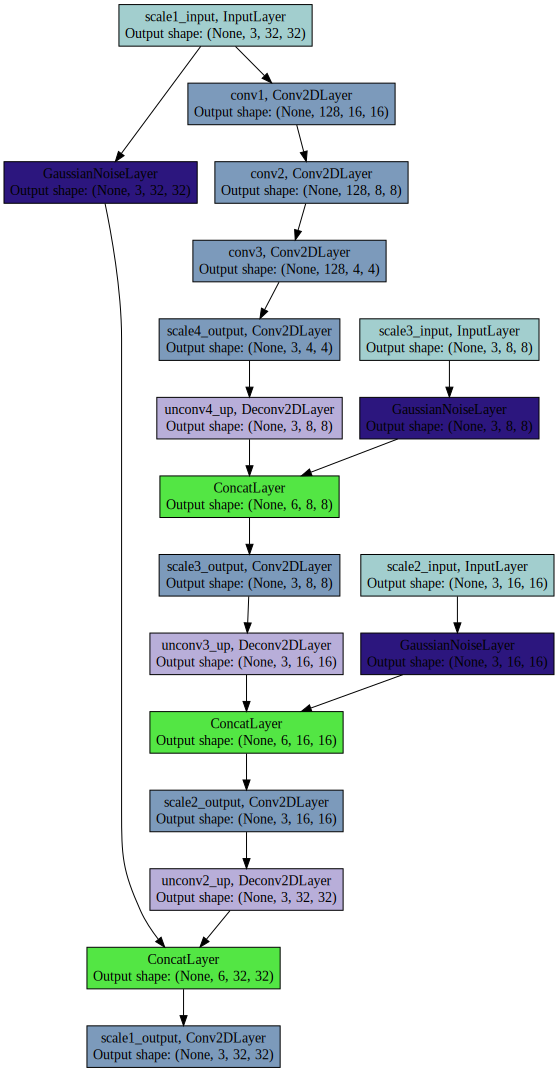

In [6]:
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG
draw_to_file(layers.get_all_layers(all_layers['scale1_output']), 'out.svg')
SVG('out.svg')

In [7]:
train_fn = theano.function(input_tensors + output_tensors, loss, updates=params_updates, on_unused_input='warn')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 3 is not part of the computational graph needed to compute the outputs: <TensorType(float32, 4D)>.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  if __name__ == '__main__':


In [8]:
predict_fn = theano.function(input_tensors, output_pred_tensors, on_unused_input='warn')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 3 is not part of the computational graph needed to compute the outputs: <TensorType(float32, 4D)>.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  if __name__ == '__main__':


In [9]:
from data import load_data
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.easy import iterate_minibatches
from lasagnekit.datasets.imagecollection import ImageCollection
from lasagnekit.datasets.transformed import Transformed
w, h = 32, 32
scale = {1: 32, 2: 16, 3: 8, 4: 4}
batch_size = 128

c = 3
folder = "{}/icons".format(os.getenv("DATA_PATH"))
data_scale1 = ImageCollection(size=(w, h), nb=1535, mode='all', folder=folder)
data_scale2 = Rescaled(data_scale1, (16, 16))
data_scale3 = Rescaled(data_scale2, (8, 8))
data_scale4 = Rescaled(data_scale3, (4, 4))

data_scale2_up = Rescaled(data_scale2, (32, 32))
data_scale3_up = Rescaled(data_scale3, (16, 16))
data_scale4_up = Rescaled(data_scale4, (8, 8))

def preprocess(x, s=32):
    x = x.reshape((x.shape[0], s, s, c))
    x = x.transpose((0, 3, 1, 2))
    return x
data_scale4.load()

data_scale2_up.load()
data_scale3_up.load()
data_scale4_up.load()

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/PIL/Image.py:870: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [ ]:
lr.set_value(0.01)
loss_list = []
for i in range(10000):
    
    
    X_scale1_out = preprocess(data_scale1.X, s=scale[1])
    X_scale2_out = preprocess(data_scale2.X, s=scale[2])
    X_scale3_out = preprocess(data_scale3.X, s=scale[3])
    X_scale4_out = preprocess(data_scale4.X, s=scale[4])   
    
    X_scale1 = preprocess(data_scale2_up.X, s=scale[1]) 
    X_scale2 = preprocess(data_scale3_up.X, s=scale[2]) 
    X_scale3 = preprocess(data_scale4_up.X, s=scale[3]) 
    X_scale4 = X_scale4_out
    
    total_loss = 0.
    for mini_batch in iterate_minibatches(len(data_scale1.X), batch_size):
        loss_val = train_fn(X_scale1[mini_batch], 
                            X_scale2[mini_batch], 
                            X_scale3[mini_batch], 
                            X_scale4[mini_batch],
                            X_scale1_out[mini_batch], 
                            X_scale2_out[mini_batch], 
                            X_scale3_out[mini_batch], 
                            X_scale4_out[mini_batch])
        total_loss += loss_val
    print(total_loss)
    loss_list.append(total_loss)
plt.plot(loss_list)

0.716116815805
0.714917335659
0.716885507107
0.716938059777
0.714972879738
0.717751972377
0.719101723284
0.719423990697
0.719752144068
0.719386745244
0.720068950206
0.718807954341
0.718515701592
0.717588767409
0.718474917114
0.72039629519
0.721516519785
0.7216270715
0.716701589525
0.716688688844
0.715732011944
0.716323841363
0.716076739132
0.717585410923
0.718310695142
0.718623723835
0.718786548823
0.718980144709
0.717201154679
0.717787113041
0.71914133057
0.72100944072
0.720424585044
0.722126405686
0.717475425452
0.719571948051
0.716329235584
0.717443201691
0.7157779634
0.716598175466
0.716233652085
0.71607490629
0.717863131315
0.71574722603
0.716720286757
0.715135790408
0.715771015733
0.715847950429
0.71614600718
0.715799286962
0.714931864291
0.717517655343
0.719731792808
0.718819055706
0.716494191438
0.716725956649
0.716149117798
0.717504434288
0.716436270624
0.717160377651
0.716798380017
0.717498727143
0.716957487166
0.717441439629
0.71810362488
0.716750089079
0.71888846904
0.71854

In [15]:
out1, out2, out3, out4 = predict_fn(X_scale1, X_scale2, X_scale3, X_scale4)

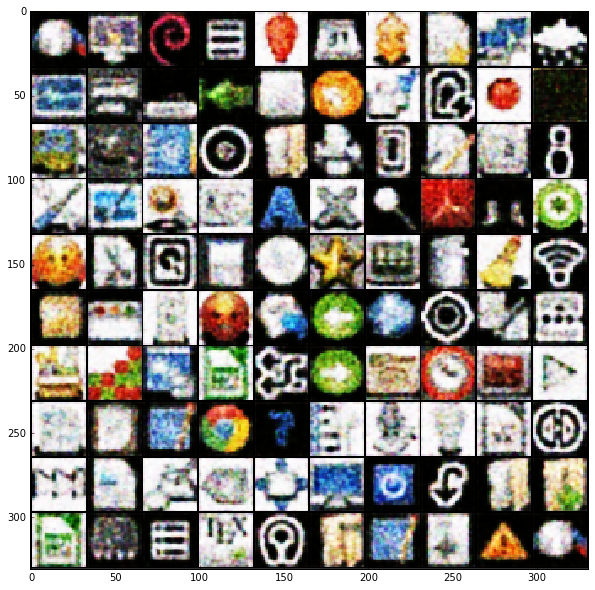

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import dispims_color
fig = plt.figure(figsize=(10, 10))
img = dispims_color(out1[0:100].transpose((0, 2, 3, 1)),border=1)
plt.imshow(img, interpolation='none')

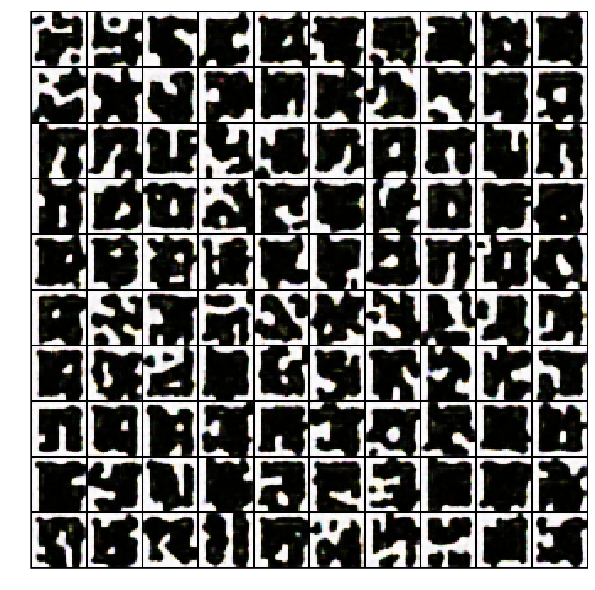

In [17]:
ss1 = np.random.uniform(size=(100, c, 32, 32))
ss2 = np.random.uniform(size=(100, c, 16, 16))
ss3 = np.random.uniform(size=(100, c, 8, 8))
ss4 = np.random.uniform(size=(100, c, 4, 4))

ss1 = ss1.astype(np.float32)
ss2 = ss2.astype(np.float32)
ss3 = ss3.astype(np.float32)
ss4 = ss4.astype(np.float32)


for i in range(100):
    ss1, ss2, ss3, ss4 = predict_fn(ss1, ss2, ss3, ss4)
    
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import dispims_color
fig = plt.figure(figsize=(10, 10))
img = dispims_color(ss1[0:100].transpose((0, 2, 3, 1)),border=1)
plt.axis('off')
plt.imshow(img, interpolation='none')